In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

Processing image... Jelly_Black.JPG
Processing image... Noir_authentique.JPG
Processing image... Jelly_Milk.JPG
Processing image... Creme_brulee.JPG
Processing image... Tentation_noir.JPG
Processing image... Arabia.JPG
Processing image... Passion_au_lait.JPG
Processing image... Jelly_White.JPG
Processing image... Amandina.JPG
Processing image... Triangolo.JPG
Processing image... Stracciatella.JPG
Processing image... Comtesse.JPG
Processing image... Noblesse.JPG
Saved cleaned prototype for Jelly_Black
Saved cleaned prototype for Noir_authentique
Saved cleaned prototype for Jelly_Milk
Saved cleaned prototype for Creme_brulee
Saved cleaned prototype for Tentation_noir
Saved cleaned prototype for Arabia
Saved cleaned prototype for Passion_au_lait
Saved cleaned prototype for Jelly_White
Saved cleaned prototype for Amandina
Saved cleaned prototype for Triangolo
Saved cleaned prototype for Stracciatella
Saved cleaned prototype for Comtesse
Saved cleaned prototype for Noblesse


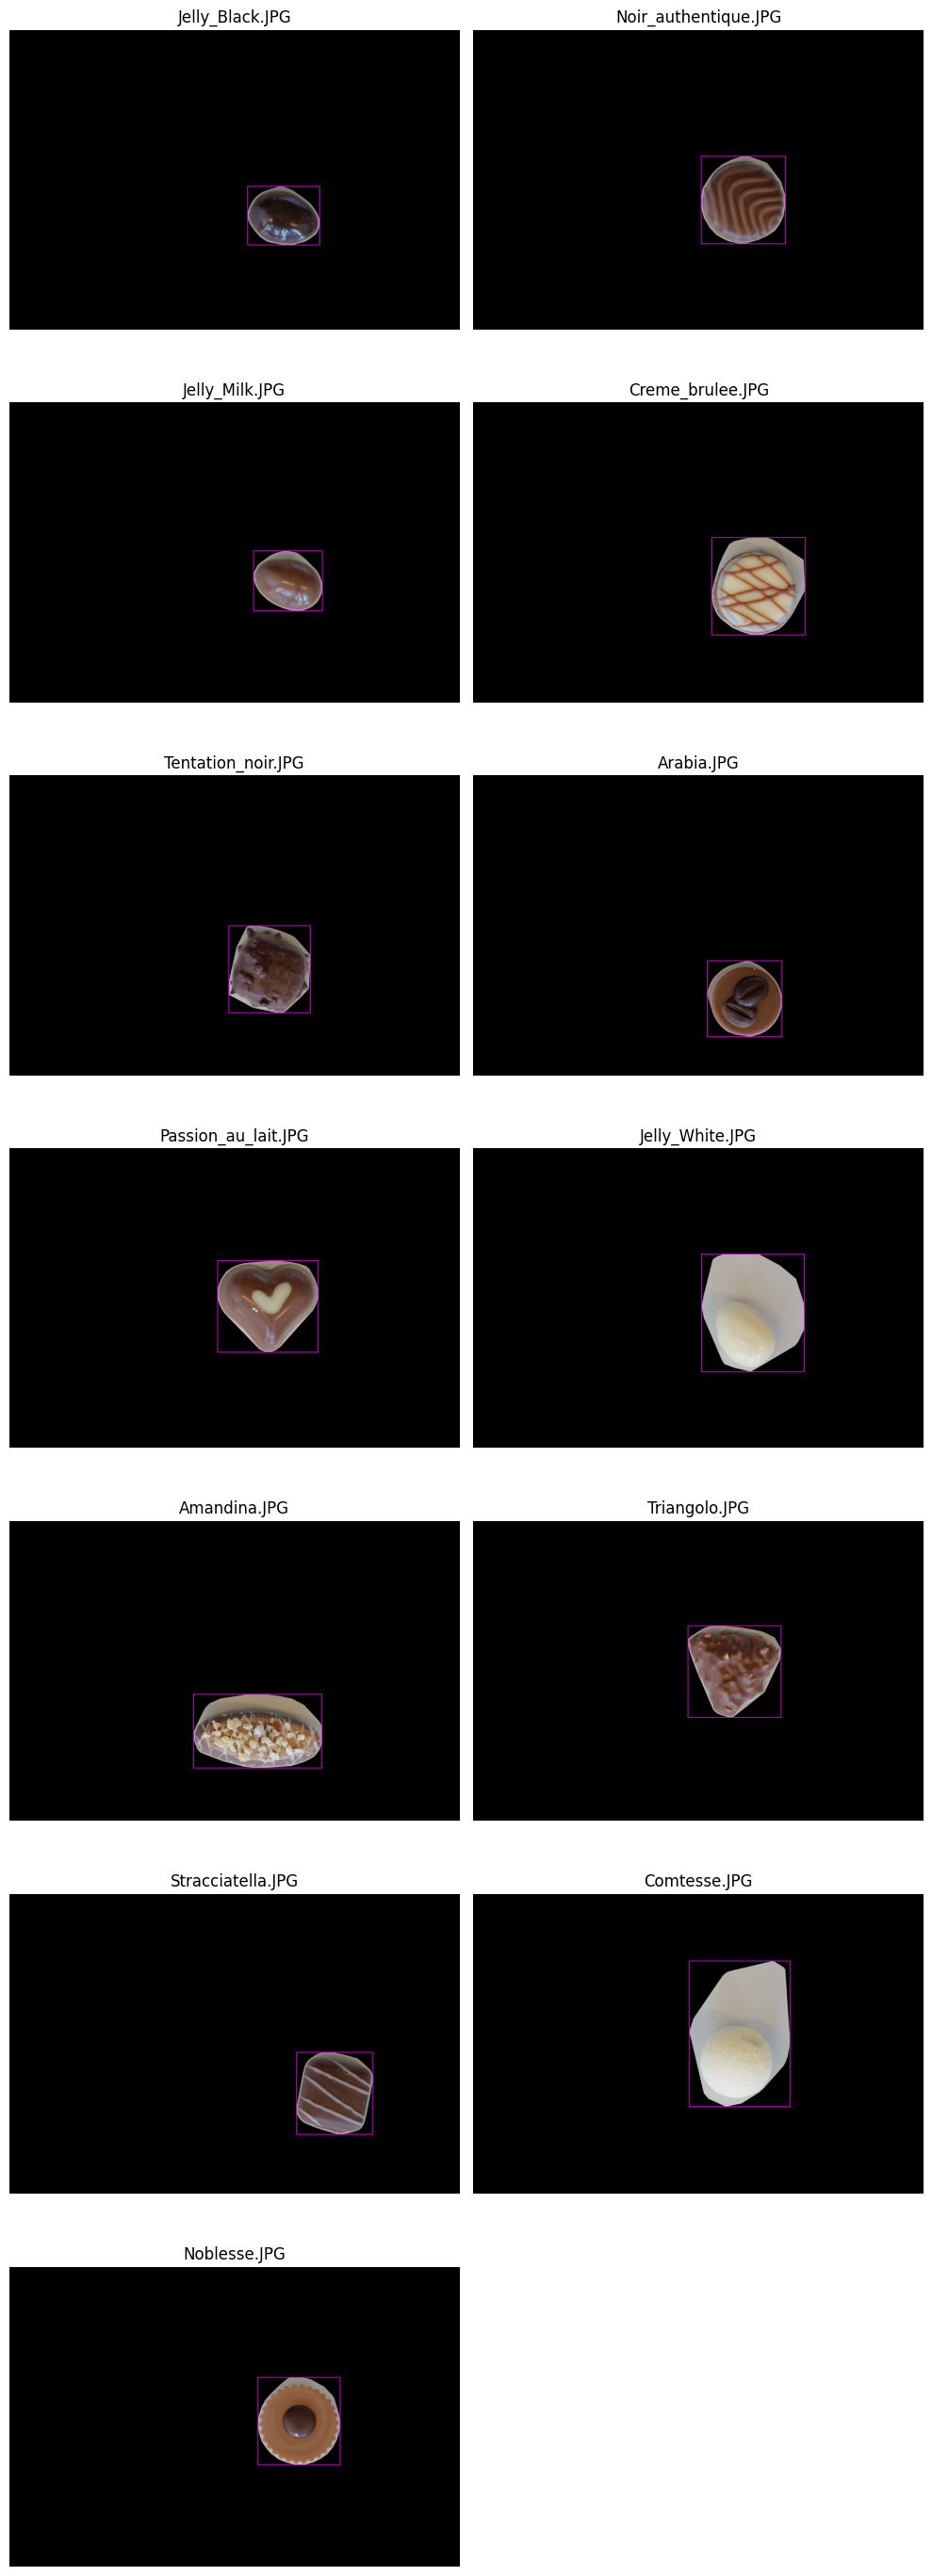

In [ ]:
def extract_chocolate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    #background = median of border pixels
    border_pixels = np.hstack([
        gray[0, :], gray[-1, :], gray[:, 0], gray[:, -1]
    ])
    bg_val = int(np.median(border_pixels))

    diff = cv2.absdiff(gray, np.full_like(gray, bg_val))

    _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.dilate(mask, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # pick largest by area
    main_cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(main_cnt)
    x, y, w_box, h_box = cv2.boundingRect(hull)

    hull_mask = np.zeros_like(gray)
    cv2.drawContours(hull_mask, [hull], -1, 255, thickness=-1)
    extracted = cv2.bitwise_and(image, image, mask=hull_mask)

    return extracted, (x, y, w_box, h_box)

folder = ''
image_files = [
    fn for fn in os.listdir(folder)
    if fn.lower().endswith(('.jpg', '.jpeg'))
]
results = []

for fn in image_files:
    print("Processing image...", fn)
    path = os.path.join(folder, fn)
    img = cv2.imread(path)
    # crop to the middle 
    h, w = img.shape[:2]
    img = img[h//4:3*h//4, w//4:3*w//4]
    if img is None:
        print(f"[!] Could not read {path}, skipping.")
        continue

    extracted, bbox = extract_chocolate(img)
    if extracted is None:
        print(f"[!] No chocolate detected in {fn}.")
        continue

    results.append((fn, img, extracted, bbox))

os.makedirs('clean_references', exist_ok=True)

for fn, orig, _, (x, y, w_box, h_box) in results:
    patch = orig[y:y+h_box, x:x+w_box]
    # resize to a common size --- think about which, now 200x200
    patch = cv2.resize(patch, (200, 200), interpolation=cv2.INTER_AREA)
    name, _ = os.path.splitext(fn)
    cv2.imwrite(f'clean_references/{name}.png', patch)
    print(f"Saved cleaned prototype for {name}")

n = len(results)
cols = 2
rows = (n + cols - 1) // cols
plt.figure(figsize=(cols * 5, rows * 4))
for idx, (fn, orig, extr, (x, y, w, h)) in enumerate(results, 1):
    ax = plt.subplot(rows, cols, idx)
    boxed = extr.copy()#orig.copy()
    cv2.rectangle(boxed, (x, y), (x + w, y + h), (255, 0, 255), 3)
    boxed = cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB)
    ax.imshow(boxed)
    ax.set_title(fn)
    ax.axis('off')

plt.tight_layout()
plt.show()

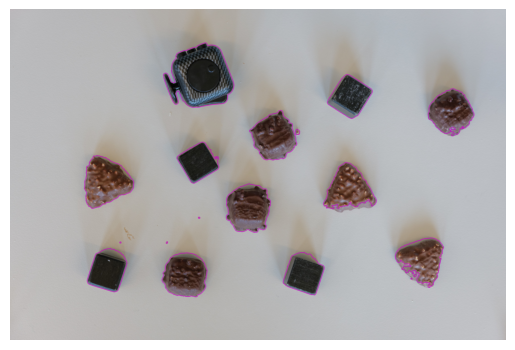

In [ ]:
image = cv2.imread('')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = gray.shape

border_pixels = np.hstack([
    gray[0, :], gray[-1, :], gray[:, 0], gray[:, -1]
])
bg_val = int(np.median(border_pixels))

diff = cv2.absdiff(gray, np.full_like(gray, bg_val))

_, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
mask = cv2.dilate(mask, kernel, iterations=2)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    cv2.drawContours(image, [cnt], -1, (200, 0, 200), 5)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

>> Loading reference histograms …
Loaded reference 'Amandina'
Loaded reference 'Arabia'
Loaded reference 'Comtesse'
Loaded reference 'Creme_brulee'
Loaded reference 'Jelly_Black'
Loaded reference 'Jelly_Milk'
Loaded reference 'Jelly_White'
Loaded reference 'Noblesse'
Loaded reference 'Noir_authentique'
Loaded reference 'Passion_au_lait'
Loaded reference 'Stracciatella'
Loaded reference 'Tentation_noir'
Loaded reference 'Triangolo'
>> Found 12 pieces


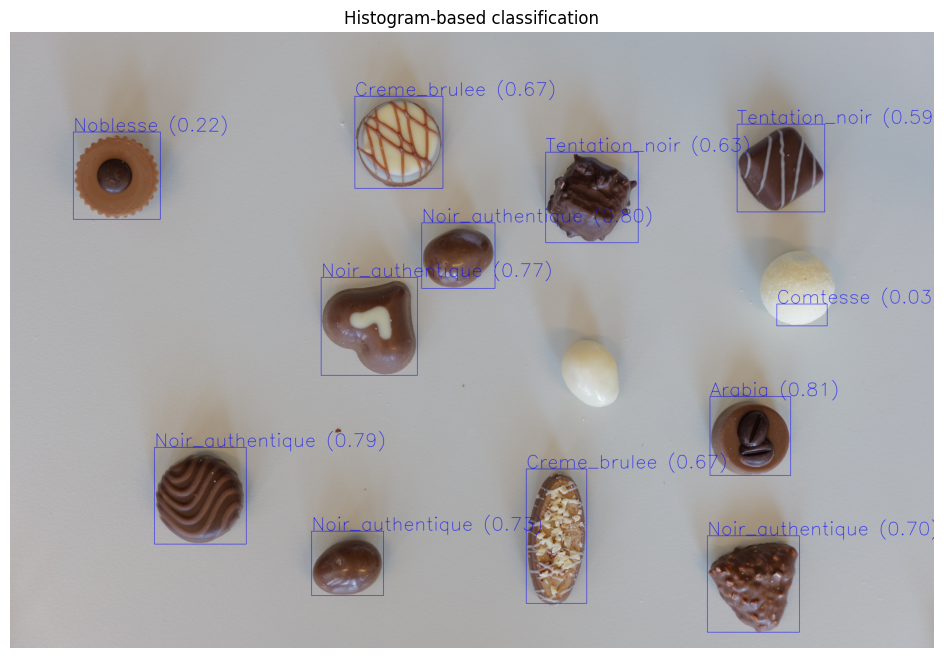

In [6]:
REF_DIR         = 'clean_references'
TEST_IMAGE      = ''  #L1000757
MIN_AREA        = 5000 # remove tiny specks
MORPH_KSIZE     = 9
HIST_CHANNELS   = [0, 2] # Hue & Value
HIST_BINS       = [50, 50]
HIST_RANGES     = [0, 180, 0, 256]  
HIST_METHOD     = cv2.HISTCMP_CORREL # correlation metric

def load_reference_hists(ref_dir):
    ref_hists = {}
    for fn in sorted(os.listdir(ref_dir)):
        if not fn.lower().endswith('.png'):
            continue
        cls_name = os.path.splitext(fn)[0]
        img = cv2.imread(os.path.join(ref_dir, fn))
        if img is None:
            raise IOError(f"Could not load {fn}")
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # full‐patch hist (we assume tight crops)
        hist = cv2.calcHist([hsv], HIST_CHANNELS, None, HIST_BINS, HIST_RANGES)
        hist = cv2.normalize(hist, hist).flatten()
        ref_hists[cls_name] = hist
        print(f"Loaded reference '{cls_name}'")
    return ref_hists


def segment_pieces(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    border = np.hstack([gray[0,:], gray[-1,:], gray[:,0], gray[:,-1]])
    bg_val = int(np.median(border))

    diff = cv2.absdiff(gray, np.full_like(gray, bg_val))
    _, mask = cv2.threshold(diff, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kern = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (MORPH_KSIZE, MORPH_KSIZE)
    )
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kern, iterations=3)
    mask = cv2.dilate(mask, kern, iterations=2)

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    pieces = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < MIN_AREA:
            continue
        x, y, w_box, h_box = cv2.boundingRect(c)
        piece_mask = np.zeros_like(gray)
        cv2.drawContours(piece_mask, [c], -1, 255, thickness=-1)
        pieces.append((piece_mask, (x, y, w_box, h_box)))
    return pieces


def classify_piece_by_hist(patch_bgr, patch_mask, ref_hists):
    hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], HIST_CHANNELS, patch_mask,
                        HIST_BINS, HIST_RANGES)
    hist = cv2.normalize(hist, hist).flatten()

    best_cls, best_score = None, -1
    for cls, ref_hist in ref_hists.items():
        score = cv2.compareHist(ref_hist, hist, HIST_METHOD)
        if score > best_score:
            best_score, best_cls = score, cls
    return best_cls, best_score



print(">> Loading reference histograms …")
ref_hists = load_reference_hists(REF_DIR)

img = cv2.imread(TEST_IMAGE)
if img is None:
    raise IOError(f"Cannot load {TEST_IMAGE}")
pieces = segment_pieces(img)
print(f">> Found {len(pieces)} pieces")

for mask, (x, y, w_box, h_box) in pieces:
    patch = img[y:y+h_box, x:x+w_box]
    submask = mask[y:y+h_box, x:x+w_box]
    cls, score = classify_piece_by_hist(patch, submask, ref_hists)
    color = (255, 0, 0)
    label = f"{cls} ({score:.2f})"

    cv2.rectangle(img, (x, y), (x+w_box, y+h_box), color, 2)
    cv2.putText(img, label, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 4, color, 2, cv2.LINE_AA)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Histogram-based classification")
plt.show()